In [1]:
import json
import os
import pandas as pd
import numpy as np
path = os.getcwd()
from classes.Block import Block #the block class
from classes.Attribute import Attribute #the block class
import networkx as nx
import itertools
from collections import Counter, OrderedDict, defaultdict
import matplotlib.pyplot as plt
import numpy as np
import math

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/kalevkim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Opening JSON file
f1 = open(f'{path}/data/entityCol1.json')
f2 = open(f'{path}/data/entityCol2.json')
 
# returns JSON object as
# a dictionary
ec1 = json.load(f1)
ec2 = json.load(f2)

In [3]:
def text_cleaning(arr):
    arr = [str(i) for i in arr]
    joint_words = ' '.join(arr)
    joint_words = str(joint_words).lower()
    val = word_tokenize(joint_words)
    valTok = list(set([w for w in val if not w.lower() in stop_words and len(w) >= 3]))
    return valTok
    

In [4]:
#function to make attribute extraction, dictionary_token making, and unique token value
#still being experimented

def extract_unique_key_val(start_ind: int, ec ):
    all_att_e = []
    all_val_e = []
    dict_E = {}
    ep_ids = []
    x = start_ind
    for d in ec:
        values_EP = []
        for key, val in (d.items()):
            if(key != 'id'): #exclude id into the calculation. ID is just for marking
                all_att_e.append(key) #allKey
                treatedVal = str(val).lower()
                values_EP.append(treatedVal)
                all_val_e.append(treatedVal) #allVal - treat number as string
            else:
                
                ep_ids.append(str(val).lower())
            
        values_EP = text_cleaning(values_EP)
        dict_E[x] = values_EP
        x = x+1
    
    att_e_keys = list(set(all_att_e))
    val_e_tokens = list(set(text_cleaning(all_val_e)))
    
    
    return (att_e_keys, val_e_tokens, dict_E, ep_ids)
    
    
attE1Keys, val_e1_tokens, dict_E1, e1_ep_ids = extract_unique_key_val(1, ec1)
attE2Keys, val_e2_tokens, dict_E2, e2_ep_ids = extract_unique_key_val(101, ec2)
all_ids = e1_ep_ids + e2_ep_ids


<h3>Token Blocking </h3>

In [5]:
def token_blocking(val_e1_tokens, val_e2_tokens, dict_E1, dict_E2):
    #common token
    #Only take token that exists in both 
    
    common_token = set(val_e1_tokens) & set(val_e2_tokens)
    
    
    #from the common token create find all entity profile
    #that has contains the token
    e1_dict_token = {}
    
    for t in common_token:
        x = [ ep for ep in dict_E1 if t in dict_E1[ep]]
        e1_dict_token[t] = x
    

    e2_dict_token = {}
    for t in common_token:
        x = [ ep for ep in dict_E2 if t in dict_E2[ep]]
        e2_dict_token[t] = x
    
    all_blocks = []
    for ct in common_token:
        new_block = Block(ct,e1_dict_token[ct], e2_dict_token[ct] )
        all_blocks.append(new_block)

    all_blocks.sort(key=lambda x: x.b_cardinality, reverse=True) #sort based on its cardinality
    
    return all_blocks
    

In [6]:
token_blocks_all = token_blocking(val_e1_tokens, val_e2_tokens, dict_E1, dict_E2)

In [7]:
#DataFrame for Visualization Purpose
#each row represents one block
token_blocks_df = pd.DataFrame([x.as_dict() for x in token_blocks_all])
token_blocks_df.head(20)

,block_name,inner_b1,in_b1_size,inner_b2,in_b2_size,b_cardin,b_size
0,foundation,"[10, 13, 15, 16, 43, 57, 77, 80, 83]",9,"[106, 107, 125, 128, 141, 144, 152, 161, 170, ...",17,153,26
1,limited,"[11, 20, 25, 38, 42, 64, 68, 87, 92, 97]",10,"[111, 116, 117, 120, 164, 168, 199, 200]",8,80,18
2,institute,"[7, 12, 19, 29, 79, 82, 89]",7,"[104, 110, 127, 148, 159, 167, 171, 190, 194, ...",11,77,18
3,associates,"[21, 53, 56, 58, 59, 60, 69, 73]",8,"[112, 121, 132, 136, 146, 162, 163, 172]",8,64,16
4,llc,"[18, 47, 62, 72, 76, 81, 94]",7,"[109, 124, 126, 134, 150, 158, 169, 173, 174]",9,63,16
5,corporation,"[3, 9, 24, 26, 27, 36, 37, 39, 49, 63]",10,"[115, 131, 140, 181, 182, 191]",6,60,16
6,incorporated,"[1, 6, 30, 46, 54, 84]",6,"[103, 129, 138, 145, 156, 187, 188, 189]",8,48,14
7,ltd,"[8, 35, 71, 74, 75, 88, 93, 96]",8,"[123, 149, 154, 155, 165, 180]",6,48,14
8,industries,"[5, 31, 45, 51, 52, 55, 78]",7,"[102, 130, 137, 143, 183, 193]",6,42,13
9,italy,"[14, 16, 22, 41, 45, 77]",6,"[105, 107, 113, 135, 137, 141]",6,36,12


<h3>Attribute Clustering</h3>

In [8]:
#Group based on the attribute for E1
#Group based on the attribute for E2

attribute_blocks_ec1 = {}
attribute_blocks_ec2 = {}

#get all values for the attributes
for attribute in attE1Keys:
    attribute_blocks_ec1[attribute]= text_cleaning(list(set([att[attribute] for att in ec1 if attribute in att.keys()])))

for attribute in attE2Keys:
    attribute_blocks_ec2[attribute] = text_cleaning(list(set([att[attribute] for att in ec2 if attribute in att.keys()])))

# Similarity Calculation

def jaccard_set(list1, list2):
    """Define Jaccard Similarity function for two sets"""
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

sim_ec1_ec2 = {}
for each in attribute_blocks_ec1:
    dict_temp = {}
    for every in attribute_blocks_ec2:
        similarity = jaccard_set(attribute_blocks_ec1[each], attribute_blocks_ec2[every])
        if similarity > 0:
            dict_temp[every] = similarity
    if(bool(dict_temp)): #check if the dictionary is not empty
        max_key = max(dict_temp, key=dict_temp.get)
        sim_ec1_ec2[each] = max_key


sim_ec2_ec1 = {}
for each in attribute_blocks_ec2:
    dict_temp = {}
    for every in attribute_blocks_ec1:
        similarity = jaccard_set(attribute_blocks_ec2[each], attribute_blocks_ec1[every])
        if similarity > 0:
            dict_temp[every] = similarity
    if(bool(dict_temp)): #check if the dictionary is not empty
        max_key = max(dict_temp, key=dict_temp.get)
        sim_ec2_ec1[each] = max_key
        
G = nx.Graph()

for each in sim_ec1_ec2:
    G.add_node(each)
    G.add_node(sim_ec1_ec2[each])
    G.add_edge(each, sim_ec1_ec2[each])
for each in sim_ec2_ec1:
    G.add_node(each)
    G.add_node(sim_ec2_ec1[each])
    G.add_edge(each, sim_ec2_ec1[each])

G_nodes = list(G.nodes)
aaabd = list(G.edges)

transitive_closures = {}
count = 0
for each in G_nodes:
    cluster = nx.node_connected_component(G, each)
    for every in cluster:
        G_nodes.remove(every)
    transitive_closures[count] = list(cluster)
    count += 1

In [9]:
sim_ec1_ec2

{'work': 'employer',
 'reportTo': 'manager',
 'country': 'country',
 'location': 'domicile',
 'gender': 'gender',
 'headQuarter': 'domicile',
 'city': 'location',
 'author': 'author',
 'corporation': 'company',
 'name': 'name',
 'company': 'company',
 'domicile': 'country',
 'field': 'position',
 'artist': 'artist',
 'corpName': 'corporation',
 'CEO': 'manager'}

In [10]:
sim_ec2_ec1

{'empName': 'name',
 'gender': 'gender',
 'country': 'country',
 'location': 'city',
 'author': 'author',
 'manager': 'CEO',
 'corporation': 'corpName',
 'name': 'name',
 'company': 'company',
 'domicile': 'country',
 'artist': 'artist',
 'position': 'field',
 'employer': 'work'}

In [11]:
#clusters that is produced
transitive_closures

{0: ['work', 'employer'],
 1: ['manager', 'CEO', 'reportTo'],
 2: ['city', 'country', 'location', 'headQuarter', 'domicile'],
 3: ['corporation', 'corpName', 'company'],
 4: ['position', 'field']}

In [12]:
def tokenize_by_attribute(ec, attcol):
    attribute_cluster_token_temp = {}
    for every in attcol:
        liste = []
        for each in ec:
            if every in each:
                wtokens = nltk.word_tokenize(str(each[every]))
                for word in wtokens:
                    liste.append(word)
        liste = text_cleaning(liste)
        attribute_cluster_token_temp[every] = liste
    return attribute_cluster_token_temp


attribute_cluster_token_temp_ec1 = tokenize_by_attribute(ec1, attE1Keys)
attribute_cluster_token_temp_ec2 = tokenize_by_attribute(ec2, attE2Keys)


In [13]:
common_token_test = {}
for each in transitive_closures:
    liste = []
    for every in transitive_closures[each]:
        if every in attribute_cluster_token_temp_ec1:
            for word in attribute_cluster_token_temp_ec1[every]:
                liste.append(word)
        if every in attribute_cluster_token_temp_ec2:
            for word in attribute_cluster_token_temp_ec2[every]:
                liste.append(word)
    common_token_test[each] = set(liste)
    


In [14]:
def create_token_dict_by_attribute(ec1, transitive_closures):
    dict_att = []
    for each in ec1:
        att_dict = {}
        for every in each:
            if every == "id":
                att_dict[every] = each[every]
            for attclu in transitive_closures:
                if every in transitive_closures[attclu]:
                    tmp = text_cleaning(nltk.word_tokenize(each[every]))
                    att_dict[every] = tmp
        dict_att.append(att_dict)
    return dict_att


ec1_token_dict_by_attribute = create_token_dict_by_attribute(ec1, transitive_closures)
ec2_token_dict_by_attribute = create_token_dict_by_attribute(ec2, transitive_closures)


In [15]:
## Token Blocking by Attribute Clusters


e1_dict_token = {}
for cluster in common_token_test:
    #call transitive closure, get a list of all entity in cluster
    kept_attribute = transitive_closures[cluster]
    kept_attribute.append('id')
    for token in common_token_test[cluster]:
        liste = []
        for entity in ec1_token_dict_by_attribute:
            entity = {k: entity[k] for k in kept_attribute if k in entity.keys()}
            #for each entity, delete key that is not in the clusters
            #and make a new dictionary entity = newDict
            
            for each in entity:
                if each != 'id' and token in entity[each]:
                    liste.append(entity['id'])
        e1_dict_token[str(cluster)+token] = list(liste)


e2_dict_token = {}
for cluster in common_token_test:
    kept_attribute = transitive_closures[cluster]
    kept_attribute.append('id')
    for token in common_token_test[cluster]:
        liste = []
        for entity in ec2_token_dict_by_attribute:
            entity = {k: entity[k] for k in kept_attribute if k in entity.keys()}
            for each in entity:
                if each != 'id' and token in entity[each]:
                    liste.append(entity['id'])
        e2_dict_token[str(cluster)+token] = list(liste)

all_blocks = []
for cluster in common_token_test:
    for token in common_token_test[cluster]:
        if len(e1_dict_token[str(cluster)+token]) > 0 and len(e2_dict_token[str(cluster)+token]) > 0:
            new_block = Block(str(cluster)+"-"+token, e1_dict_token[str(cluster)+token], e2_dict_token[str(cluster)+token])
            all_blocks.append(new_block)
all_blocks.sort(key=lambda x: x.b_cardinality, reverse=True)
token_blocks_by_attribute_df = pd.DataFrame([x.as_dict() for x in all_blocks])
display(token_blocks_by_attribute_df)


,block_name,inner_b1,in_b1_size,inner_b2,in_b2_size,b_cardin,b_size
0,0-foundation,"[57, 77, 80, 83]",4,"[125, 128, 141, 144, 152, 161, 170, 175, 176, ...",15,60,19
1,0-associates,"[53, 56, 58, 59, 60, 69, 73]",7,"[121, 132, 136, 146, 162, 163, 172]",7,49,14
2,0-llc,"[62, 72, 76, 81, 94]",5,"[124, 126, 134, 150, 158, 169, 173, 174]",8,40,13
3,2-italy,"[14, 16, 22, 41, 45, 77]",6,"[105, 107, 113, 135, 137, 141]",6,36,12
4,2-spain,"[6, 9, 25, 49]",4,"[103, 116, 133, 136, 145, 172, 173, 174]",8,32,12
...,...,...,...,...,...,...,...
120,3-hendrerit,[24],1,[115],1,1,2
121,3-sed,[5],1,[102],1,1,2
122,3-consectetuer,[25],1,[116],1,1,2
123,3-mollis,[14],1,[105],1,1,2


<h3>Meta-blocking

In [16]:
#G1 = Weighting Scheme: Common block, Prunning: WEP
#G2 = Weighting Scheme: Jaccard simmilarity, Prunning: WEP
#G3 = Weighting Scheme: Common block, Prunning: Cardinality Node Prunning 
#G4 = Weighting Scheme: Jaccard simmilarity, Prunning: Cardinality Node Prunning

In [40]:
def create_graph(blocks, weighting_scheme = 'cbs'):
    G = nx.Graph()
    if weighting_scheme == 'jaccard': #cb
        edges = weight_edge_jac(blocks)
    else:
        edges = weight_edge_cb(blocks)

    for nodes in edges:
        G.add_edge(nodes[0], nodes[1], weight=edges[nodes])
    G.remove_nodes_from(list(nx.isolates(G)))
    
    return G, edges

def weight_edge_cb(token_blocks_all):
    all_pairs = []
    for b in token_blocks_all:
        ib1 = b.ib1
        ib2 = b.ib2
        b_pairs = list(itertools.product(ib1, ib2)) #all possible combinations of the two list
        b_pairs = [list(p) for p in b_pairs]
        for pair in b_pairs:
            pair.sort()
        all_pairs.append(b_pairs)

    all_pairs_flat = [item for sublist in all_pairs for item in sublist] #flatten it
    pairs_dict = Counter(map(tuple, all_pairs_flat))
    pairs_dict = OrderedDict(sorted(pairs_dict.items(), key=lambda x: x[1], reverse=True))
    return pairs_dict

def weight_edge_jac(token_blocks_all):
    
    all_inner_block = []
    for b in token_blocks_all:
        ib1 = b.ib1
        ib2 = b.ib2
        comb_inner_b = list(ib1 + ib2)
        all_inner_block.append(comb_inner_b)
        
    all_block_flat = [item for sublist in all_inner_block for item in sublist]
    count_ep = Counter(all_block_flat)
    
    all_pairs = []
    for b in token_blocks_all:
        ib1 = b.ib1
        ib2 = b.ib2
        b_pairs = list(itertools.product(ib1, ib2)) #all possible combinations of the two list
        b_pairs = [list(p) for p in b_pairs]
        for pair in b_pairs:
            pair.sort()
        all_pairs.append(b_pairs)

    all_pairs_flat = [item for sublist in all_pairs for item in sublist]
    pairs_dict = Counter(map(tuple, all_pairs_flat))
    pairs_dict = OrderedDict(sorted(pairs_dict.items(), key=lambda x: x[1], reverse=True))
    
    for p in pairs_dict:
        jac_weight = pairs_dict[p]/(count_ep[p[0]] + count_ep[p[1]] - pairs_dict[p])
        pairs_dict[p] = jac_weight
    
    return pairs_dict

<h4>Graph 1 (WS: CBS) before prunning with Weight Edge Prunning</h4>

average edge weight 1.1967984934086628
Before prunning num. of edges: 1062
Before prunning num. of nodes: 201


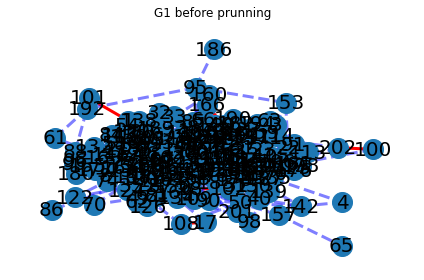

In [41]:
G1, g1_edges = create_graph(token_blocks_all)

pos = nx.spring_layout(G1, seed=7)  # positions for all nodes - seed for reproducibility

#find average weight:
tot_weight = []
for w in g1_edges:
    tot_weight.append(g1_edges[w])
average_edge_weight = np.average(tot_weight)
print("average edge weight", average_edge_weight)

print("Before prunning num. of edges:", len(G1.edges()))
print("Before prunning num. of nodes:", len(G1.nodes()))

# nodes
nx.draw_networkx_nodes(G1, pos, node_size=400)

elarge = [(u, v) for (u, v, d) in G1.edges(data=True) if d["weight"] > average_edge_weight]
esmall = [(u, v) for (u, v, d) in G1.edges(data=True) if d["weight"] <= average_edge_weight]

# edges
nx.draw_networkx_edges(G1, pos, edgelist=elarge, width=3, edge_color="r")
nx.draw_networkx_edges(G1, pos, edgelist=esmall, width=3, alpha=0.5, edge_color="b", style="dashed")

nx.draw_networkx_labels(G1, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
plt.title("G1 before prunning")
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

After prunning num. of edges: 92
After prunning num. of nodes: 114


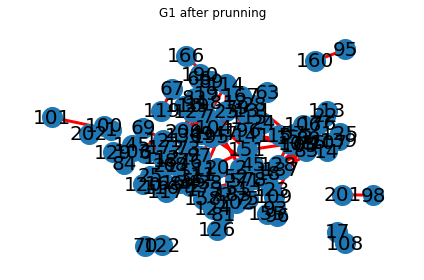

In [46]:
#remove edges that are below the treshold value (average weight)
removed_edges = [(a,b) for a, b, attrs in G1.edges(data=True) if attrs["weight"] <= average_edge_weight]
G1.remove_edges_from(removed_edges)

#remove isolated nodes
G1.remove_nodes_from(list(nx.isolates(G1)))


print("After prunning num. of edges:", len(G1.edges()))
print("After prunning num. of nodes:", len(G1.nodes()))

# nodes
nx.draw_networkx_nodes(G1, pos, node_size=400)

elarge = [(u, v) for (u, v, d) in G1.edges(data=True) if d["weight"] > average_edge_weight]
esmall = [(u, v) for (u, v, d) in G1.edges(data=True) if d["weight"] <= average_edge_weight]

# edges
nx.draw_networkx_edges(G1, pos, edgelist=elarge, width=3, edge_color="r")
nx.draw_networkx_edges(G1, pos, edgelist=esmall, width=3, alpha=0.5, edge_color="b", style="dashed")

nx.draw_networkx_labels(G1, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.title("G1 after prunning")
plt.tight_layout()
plt.show()


<h4>Graph 2 (WS = Jaccard Sim) before prunning with Weight Edge Prunning

Before prunning num. of edges: 1062
Before prunning num. of nodes: 201
average edge weight 0.18884762705384175


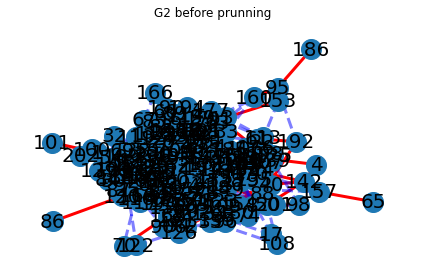

In [43]:
G2, g2_edges = create_graph(token_blocks_all, "jaccard")

#make an instance G3 for the second prunning
G4 = G2
g4_edges = g2_edges

pos = nx.spring_layout(G2, seed=7)  # positions for all nodes - seed for reproducibility

print("Before prunning num. of edges:", len(G2.edges()))
print("Before prunning num. of nodes:", len(G2.nodes()))

#find average weight:
tot_weight = []
for w in g2_edges:
    tot_weight.append(g2_edges[w])
average_edge_weight = np.average(tot_weight)
print("average edge weight", average_edge_weight)

# nodes
nx.draw_networkx_nodes(G2, pos, node_size=400)

elarge = [(u, v) for (u, v, d) in G2.edges(data=True) if d["weight"] > average_edge_weight]
esmall = [(u, v) for (u, v, d) in G2.edges(data=True) if d["weight"] <= average_edge_weight]

# edges
# edges
nx.draw_networkx_edges(G2, pos, edgelist=elarge, width=3, edge_color="r")
nx.draw_networkx_edges(G2, pos, edgelist=esmall, width=3, alpha=0.5, edge_color="b", style="dashed")
nx.draw_networkx_labels(G2, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.title("G2 before prunning")
plt.tight_layout()
plt.show()


After prunning num. of edges: 304
After prunning num. of nodes: 194


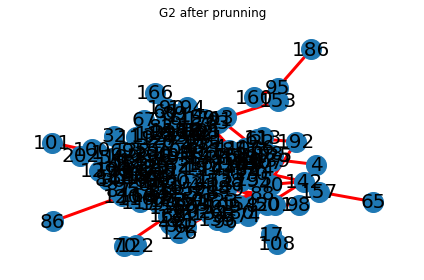

In [47]:
#remove edges that are below the treshold value (average weight)
removed_edges = [(a,b) for a, b, attrs in G2.edges(data=True) if attrs["weight"] <= average_edge_weight]
G2.remove_edges_from(removed_edges)

#remove isolated nodes
G2.remove_nodes_from(list(nx.isolates(G2)))


print("After prunning num. of edges:", len(G2.edges()))
print("After prunning num. of nodes:", len(G2.nodes()))


# nodes
nx.draw_networkx_nodes(G2, pos, node_size=400)
elarge = [(u, v) for (u, v, d) in G2.edges(data=True) if d["weight"] > average_edge_weight]
esmall = [(u, v) for (u, v, d) in G2.edges(data=True) if d["weight"] <=average_edge_weight]

# edges
nx.draw_networkx_edges(G2, pos, edgelist=elarge, width=3, edge_color="r")
nx.draw_networkx_edges(G2, pos, edgelist=esmall, width=3, alpha=0.5, edge_color="b", style="dashed")
nx.draw_networkx_labels(G2, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.title("G2 after prunning")
plt.tight_layout()
plt.show()

In [36]:
#Prunning with node cardinality
def cardinality_node_prunning(G):
    e_out = []
    vertices = G.nodes()
    for v in vertices:
        sorted_stack = []
        edge_weight = {}
        
        #get neighbors
        neighbors = [n for n in G.neighbors(v)]
        k = math.ceil(len(neighbors)*0.1) #cardinality treshold

    
        edges_of_v = list(G.edges(v))
        
        ev_dict = {}
        for ev in edges_of_v:
            weight = G[ev[0]][ev[1]]['weight']
            ev_dict[(ev[0], ev[1])] = weight
        
        sorted_ev_dict = {k: v for k, v in sorted(ev_dict.items(), key=lambda item: item[1], reverse=True)}

        
        for edge, weight in sorted_ev_dict.items():
            while k > len(sorted_stack):
                sorted_stack.append(edge)
        
        sorted_stack =  list(set(sorted_stack))
        
        for edge, weight in sorted_ev_dict.items():
            if edge in sorted_stack:
                e_out.append(edge)
    e_out = list(set(e_out))
                
    return e_out

<h4>Graph 3 (WS: CBS) before prunning with Cardinality Node Prunning</h4>

Before prunning num. of edges: 1062
Before prunning num. of nodes: 201


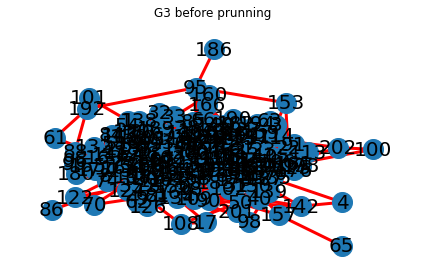

In [49]:
G3, g3_edges = create_graph(token_blocks_all)
G3.remove_nodes_from(list(nx.isolates(G3)))

pos = nx.spring_layout(G3, seed=7)  # positions for all nodes - seed for reproducibility

print("Before prunning num. of edges:", len(G3.edges()))
print("Before prunning num. of nodes:", len(G3.nodes()))


nx.draw_networkx_nodes(G3, pos, node_size=400)
# edges
nx.draw_networkx_edges(G3, pos, width=3, edge_color="r")
nx.draw_networkx_labels(G3, pos, font_size=20, font_family="sans-serif")



ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.title("G3 before prunning")
plt.tight_layout()
plt.show()

After prunning num. of edges: 44
After prunning num. of nodes: 88


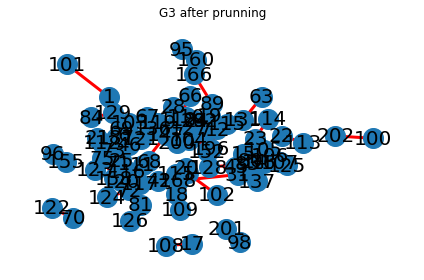

In [52]:
retained_edges_G3 = cardinality_node_prunning(G3)
original_edges_g3 = list(G3.edges())
deleted_edges_g3 = list(set(original_edges_g3) - set(retained_edges_G3))
for dedge in deleted_edges_g3:
    G3.remove_edge(dedge[0], dedge[1])
    
#remove isolated nodes
G3.remove_nodes_from(list(nx.isolates(G3)))

print("After prunning num. of edges:", len(G3.edges()))
print("After prunning num. of nodes:", len(G3.nodes()))
    
nx.draw_networkx_nodes(G3, pos, node_size=400)
# edges
nx.draw_networkx_edges(G3, pos, width=3, edge_color="r")
nx.draw_networkx_labels(G3, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.title("G3 after prunning")
plt.tight_layout()

plt.show()

<h4>Graph 4 (WS: Jaccard similarity) before prunning with Cardinality Node Prunning</h4>

Before prunning num. of edges: 1062
Before prunning num. of nodes: 201


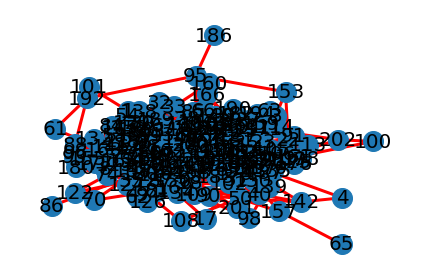

In [39]:
G4, g4_edges = create_graph(token_blocks_all, "jaccard")
G4.remove_nodes_from(list(nx.isolates(G4)))

print("Before prunning num. of edges:", len(G4.edges()))
print("Before prunning num. of nodes:", len(G4.nodes()))

nx.draw_networkx_nodes(G4, pos, node_size=400)
# edges
nx.draw_networkx_edges(G4, pos, width=3, edge_color="r")
nx.draw_networkx_labels(G4, pos, font_size=20, font_family="sans-serif")



ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

After prunning num. of edges: 78
After prunning num. of nodes: 139


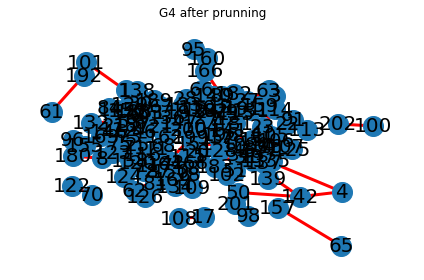

In [51]:
retained_edges_g4 = cardinality_node_prunning(G4)
original_edges_g4 = list(G4.edges())
deleted_edges_g4 = list(set(original_edges_g4) - set(retained_edges_g4))
for dedge in deleted_edges_g4:
    G4.remove_edge(dedge[0], dedge[1])
    
#remove isolated nodes
G4.remove_nodes_from(list(nx.isolates(G4)))

print("After prunning num. of edges:", len(G4.edges()))
print("After prunning num. of nodes:", len(G4.nodes()))
    
nx.draw_networkx_nodes(G4, pos, node_size=400)
# edges
nx.draw_networkx_edges(G4, pos, width=3, edge_color="r")
nx.draw_networkx_labels(G4, pos, font_size=20, font_family="sans-serif")



ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.title("G4 after prunning")
plt.tight_layout()
plt.show()